# Code to make Figure 3
- SOM pattern composites over southern Ross Sea for atmosphere variables
- Notebook by Alice DuVivier (NCAR)
- June 2023

In [1]:
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product
import pickle
import dask
import utils
import cmocean
import geopandas as gpd

## Specify "winning" SOM parameters

In [2]:
# set paired values for possible winning maps based on Sammon maps
vars_in          = ['aice_d']  # training dataset
som_grid_rows    = [3]    # (y-axis)
som_grid_cols    = [3]    # (x-axis)
sigs             = [1.0]
lrs              = [0.005]
nitrs            = [100000]
ranks            = [9]

In [3]:
# MANUAL CHANGING REQUIRED HERE
n = 0
var_in = vars_in[n]
som_row = som_grid_rows[n]
som_col = som_grid_cols[n]
sig = sigs[n]
lr = lrs[n]
n_iter = nitrs[n]
rank = ranks[n]

In [4]:
# set the location of the already extracted training data
path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v5/'
path_out = path_in+'figure_code/final_figures/'
# set shape files info
fname= '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v4/USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp' 

In [5]:
# construct the input name from this, set as output for figure names
fin = 'som_Ross_'+var_in+'_'+str(som_row)+'x'+str(som_col)+'_rank_'+str(rank)+'_sig'+str(sig)+'_lr'+str(lr)+'_iter'+str(n_iter)
print(fin)

som_Ross_aice_d_3x3_rank_9_sig1.0_lr0.005_iter100000


### Load training data to interpret SOM

In [6]:
def normalize_data(data):
    """
    Function for normalizing data prior to training using z-score
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [7]:
# open file saved in earlier notebook (soms_antarctica-gettingdata.ipynb)
subset = xr.open_dataset(path_in+'training_data_region_Ross_'+var_in+'.nc')

# assign to numpy array object
subsetarray = subset['train_data'].values

# set data
data = normalize_data(subsetarray)

# set data input length
input_length = subsetarray.shape[1]    # using preprocessed data array; Number of the elements of the vectors in input.


### Load Pickle with winning combos

In [8]:
# open pickle
with open(path_in+'/pickles/'+fin+'.p', 'rb') as infile:
    som = pickle.load(infile)

In [9]:
# double check qerror
qerr = som.quantization_error(data)
print('quantization error: '+str(qerr))

quantization error: 5.796123268140545


In [10]:
print(path_out)

/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v5/figure_code/final_figures/


In [11]:
# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(som_row),range(som_col))]
winmap = {key: [] for key in keys}

In [12]:
# set frequencies
frequencies = 100.*((som.activation_response(data))/sum(sum(som.activation_response(data))))
#verify the total frequency is 100%
total = sum(sum(frequencies))

# grab the indices for the data within the SOM lattice
for i, x in enumerate(data):
    winmap[som.winner(x)].append(i) 

# create list of the dictionary keys
som_keys = list(winmap.keys())
print(f"Number of composite maps: {len(som_keys)}")
print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")

Number of composite maps: 9
The rows and columns of the SOM lattice to use to grab SOM indexes:
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


## Plot composite maps

### Specify variables to plot

In [13]:
# set path to the pulled data
# Note data is for larger area than only training points
# this data has been processed all the same 'time' coordinates as training data
data_path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/DATA/data_for_composites/'

# set what variables we can plot
vars_composite_in = ['U10', 'PSL']


In [40]:
# USER CHOOSE WHICH VARIABLE TO PLOT: 0-1
n = 1
var_in = vars_composite_in[n] 

In [41]:
# file name for training variable only here 
fin_composite = 'antarctic_data_for_som_composites_'+var_in

In [42]:
# load data
ds = xr.open_mfdataset(data_path_in+fin_composite+'.nc')

In [43]:
data = ds.data.where((ds.lon > 140.0) & (ds.lon < 230.0) & (ds.lat < -68.0))

In [44]:
# explicitly load data so that it doesn't take forever later on during mean
data = data.load()

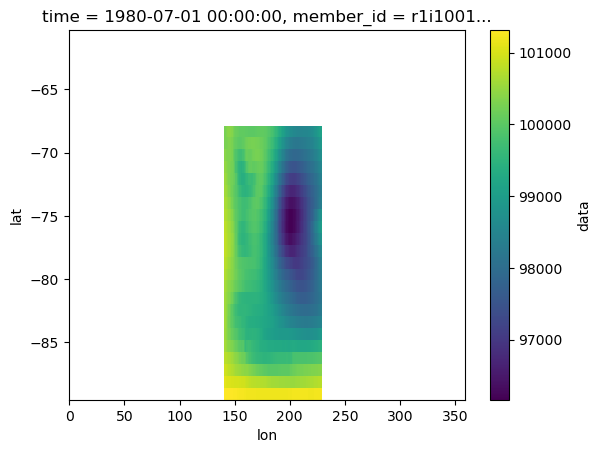

In [45]:
data.isel(training_times=0).plot()

## Calculate composite node averages

In [46]:
nodes = list(range(0,len(som_keys),1))

In [47]:
# make numpy arrays to fill with frequencies
node_all = np.zeros([len(nodes),len(ds.lat),len(ds.lon)])

# loop through the different maps to get the indices of training data that map there
for map_num in range(len(som_keys)):
#for map_num in range(len(som_keys))[0:1]:
    # get indices of training data that mapped to this node
    inds = winmap[som_keys[map_num]]
    print(len(inds))
    # grab the compositing data that corresponds to those training times
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        ds_sub = data.isel(training_times=inds)      
    # grab data for the subset of years and average
    temp_all = ds_sub.mean(dim="training_times", skipna=True)
    # populate the allocated arrays
    node_all[map_num,:,:] = temp_all.data


22148
23600
11869
34819
26379
18563
36848
36003
22071


In [48]:
print(node_all.shape)

(9, 31, 288)


In [49]:
# convert the numpy array to a xarray
node_composite_all = xr.DataArray(node_all,dims=('node','lat','lon'))

In [50]:
# set coordinate arrays
node_composite_all['node'] = nodes
node_composite_all['lat'] = ds.lat
node_composite_all['lon'] = ds.lon

## Calculate node anomalies

In [51]:
# calculate winter mean against which to do anomalies
data_mean = data.mean(dim='training_times')

In [52]:
node_anomaly_all = node_composite_all - data_mean

In [53]:
node_anomaly_all

<xarray.DataArray (node: 9, lat: 31, lon: 288)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * node     (node) int64 0 1 2 3 4 5 6 7 8
  * lat      (lat) float64 -89.06 -88.12 -87.17 -86.23 ... -62.67 -61.73 -60.79
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

## Actually do plots

In [54]:
# convert to hPa
if var_in == 'PSL':
    node_composite_all = node_composite_all/100.

In [55]:
# Set plotting limits
lat_max = -72
lat_min = -80
lon_max = 200
lon_min = 160
lon_avg = 190

In [56]:
#set shape files info
shdf = gpd.read_file(fname)
# This line is important. Here we convert the projection from the shapefile one to the cartopy one 
shdf = shdf.to_crs(ccrs.SouthPolarStereo())

# Shapefile projection conversion
shdf = gpd.read_file(fname)
shdf = shdf.to_crs(ccrs.SouthPolarStereo(central_longitude=lon_avg))


In [57]:
# set some labeling things
node_labels=['0a','0b','0c','1a','1b','1c','2a','2b','2c']

# set missing value color
grey_tone = 0.5

# set limits
if var_in == 'U10':
    print(var_in)
    title_in = '10m wind speed'
    # node average info
    units = '(m/s)'
    levels_in = np.arange(0,13,1)  
    ticks_in = [0,2,4,6,8,10,12]
    cmap_in = cmocean.cm.matter
    ext = 'max'
    # node anomaly info
    levels_diff = np.arange(-5,5.5,0.5) 
    ticks_diff = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
    levels_pcnt_diff = np.arange(-100,110,10)
    ticks_pcnt_diff = [-80,-60,-40,-20,0,20,40,60,80]
    cmap_diff = cmocean.cm.diff
    # prefixes
    pref_1 = 'd) '
    pref_2 = 'e) '
    pref_3 = 'f) '
if var_in == 'PSL':
    print(var_in)
    title_in = 'Sea Level Pressure'
    units = '(hPa)'
    # node average info
    levels_in = np.arange(970,1012,2)
    ticks_in = [970,980,990,1000,1010]
    cmap_in = cmocean.cm.tempo
    cmap_in = cmap_in.reversed()
    ext = 'both'
    # node anomaly info
    levels_diff = np.arange(-8,9,1) 
    ticks_diff = [-8,-6,-4,-2,0,2,4,6,8]
    levels_pcnt_diff = np.arange(-10,11,1)
    ticks_pcnt_diff = [-10,-5,0,5,10]
    cmap_diff = cmocean.cm.diff
    # prefixes
    pref_1 = 'g) '
    pref_2 = 'h) '
    pref_3 = 'i) '

PSL


### Plot entire SOM with all nodes

In [58]:
fout = path_out+'supp_fig_SOM_'+var_in

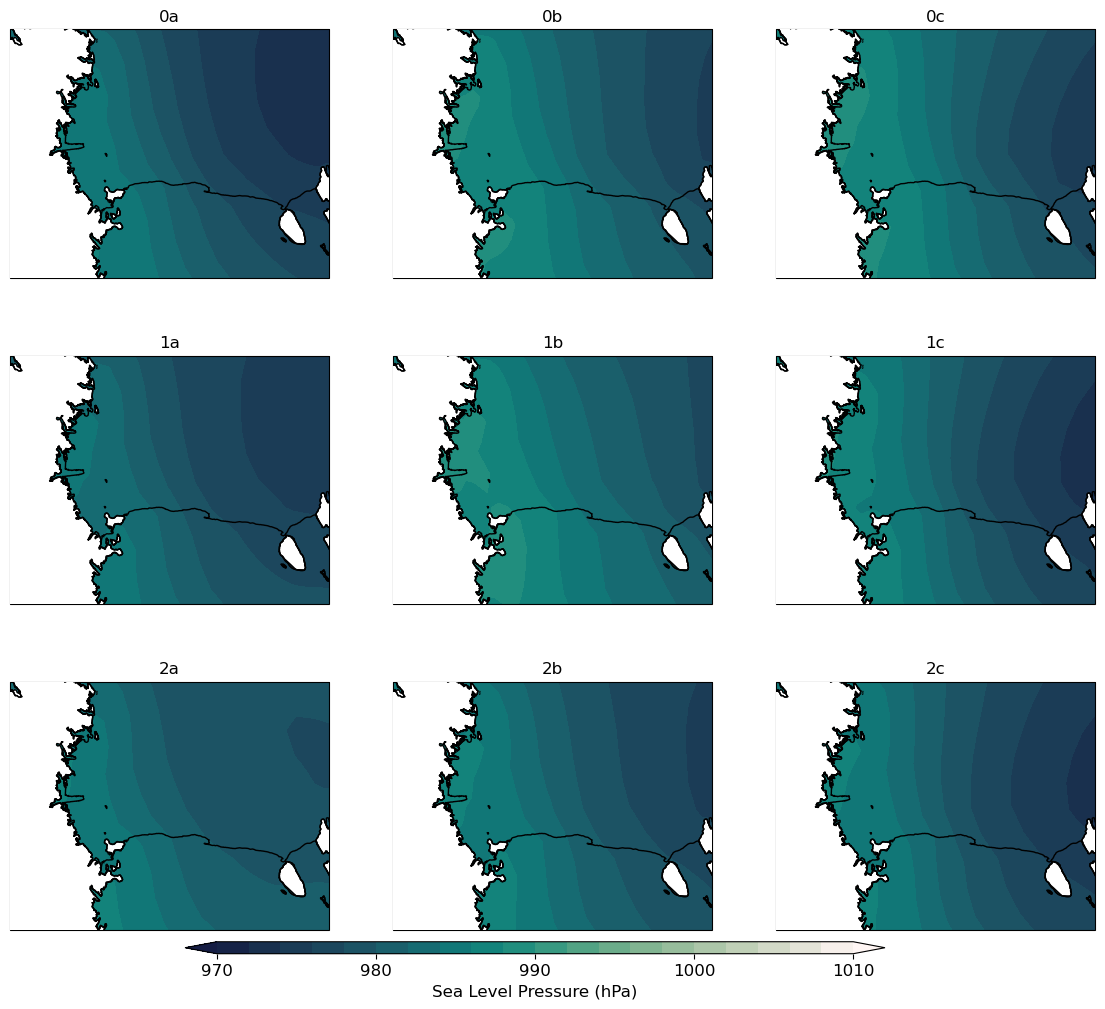

In [59]:
## Plot the composite from *all* data
# get lat/lon
lats = ds.lat
lons = ds.lon

# set some of the plot info
fig, axs = plt.subplots(som_row, som_col, subplot_kw={'projection':ccrs.Stereographic(central_longitude=lon_avg)}, figsize=(14,12))

# loop through the different maps to get the indices of training data that map there
for map_num in range(len(som_keys)):
    # set face colors
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_facecolor([grey_tone,grey_tone,grey_tone,1])

    ### plot the node composite average
    # grab the data for this decade
    data_temp = node_composite_all.isel(node=map_num)
    # plot
    cs = axs[som_keys[map_num][0],som_keys[map_num][1]].contourf(lons,lats, 
                                                               data_temp,
                                                               transform=ccrs.PlateCarree(),
                                                               cmap = cmap_in,
                                                               levels = levels_in, extend=ext)
    # set final plot details
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_extent([lon_min,lon_max,lat_min,lat_max])
    axs[som_keys[map_num][0],som_keys[map_num][1]].add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(node_labels[map_num])
    # Plotting shapefile
    axs[som_keys[map_num][0],som_keys[map_num][1]].add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# colorbar stuff
cbar_ax = fig.add_axes([0.25,0.1,0.5,0.01]) 
cbar = fig.colorbar(cs, cax=cbar_ax, ticks=ticks_in[:], orientation='horizontal', extend=ext)
cbar.ax.set_xticklabels(list(ticks_in))
cbar.ax.tick_params(labelsize=12)
cbar.set_label(title_in+' '+units, fontsize=12)
    
# save figure
plt.savefig(fout, bbox_inches='tight', dpi=200)

### Plot just the two contrasting nodes

In [60]:
fout = path_out+'fig_3_'+var_in

/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


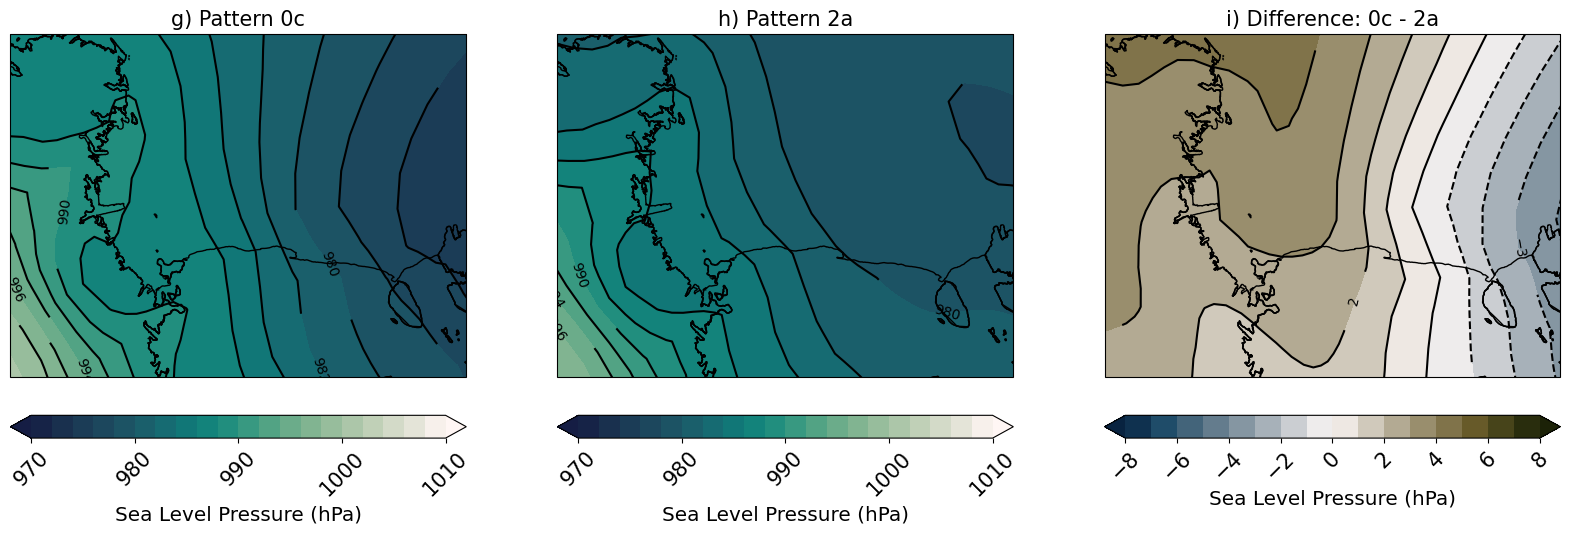

In [61]:
## Plot the composite from only nodes 0c and 2a
# get lat/lon
lats = ds.lat
lons = ds.lon

# select data
data_temp_1 = node_composite_all.isel(node=2)
data_temp_2 = node_composite_all.isel(node=6)
diff = data_temp_1 - data_temp_2
pcnt_diff = 100*((data_temp_1 - data_temp_2)/data_temp_2)

# create figure
fig = plt.figure(figsize=(20,10))

# plot the subplots - note it's nrow x ncol x index (starting upper left)
## plot 1
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_temp_1,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend=ext)
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,fraction=0.04,pad=0.05)
cbar.ax.tick_params(labelsize=15,rotation=45)
cbar.set_label(title_in+' '+units, fontsize='x-large')
# add contours overtop
this2 = ax.contour(lons,lats,
                   data_temp_1,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_in,extend=ext,linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_1+'Pattern 0c',fontsize=15)

## plot 2
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_temp_2,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend=ext)
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,fraction=0.04,pad=0.05)
cbar.ax.tick_params(labelsize=15,rotation=45)
cbar.set_label(title_in+' '+units, fontsize='x-large')
# add contours overtop
this2 = ax.contour(lons,lats,
                   data_temp_2,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_in,extend=ext,linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_2+'Pattern 2a',fontsize=15)

## plot 3
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   diff,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_diff,
                   levels=levels_diff, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,fraction=0.04,pad=0.05)
cbar.ax.tick_params(labelsize=15,rotation=45)
cbar.set_label(title_in+' '+units, fontsize='x-large')
# add contours overtop
this2 = ax.contour(lons,lats,
                   diff,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_diff,extend='both',linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=levels_diff)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_3+'Difference: 0c - 2a',fontsize=15)

# Finalize figure and save
if var_in == 'U10':
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)

/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


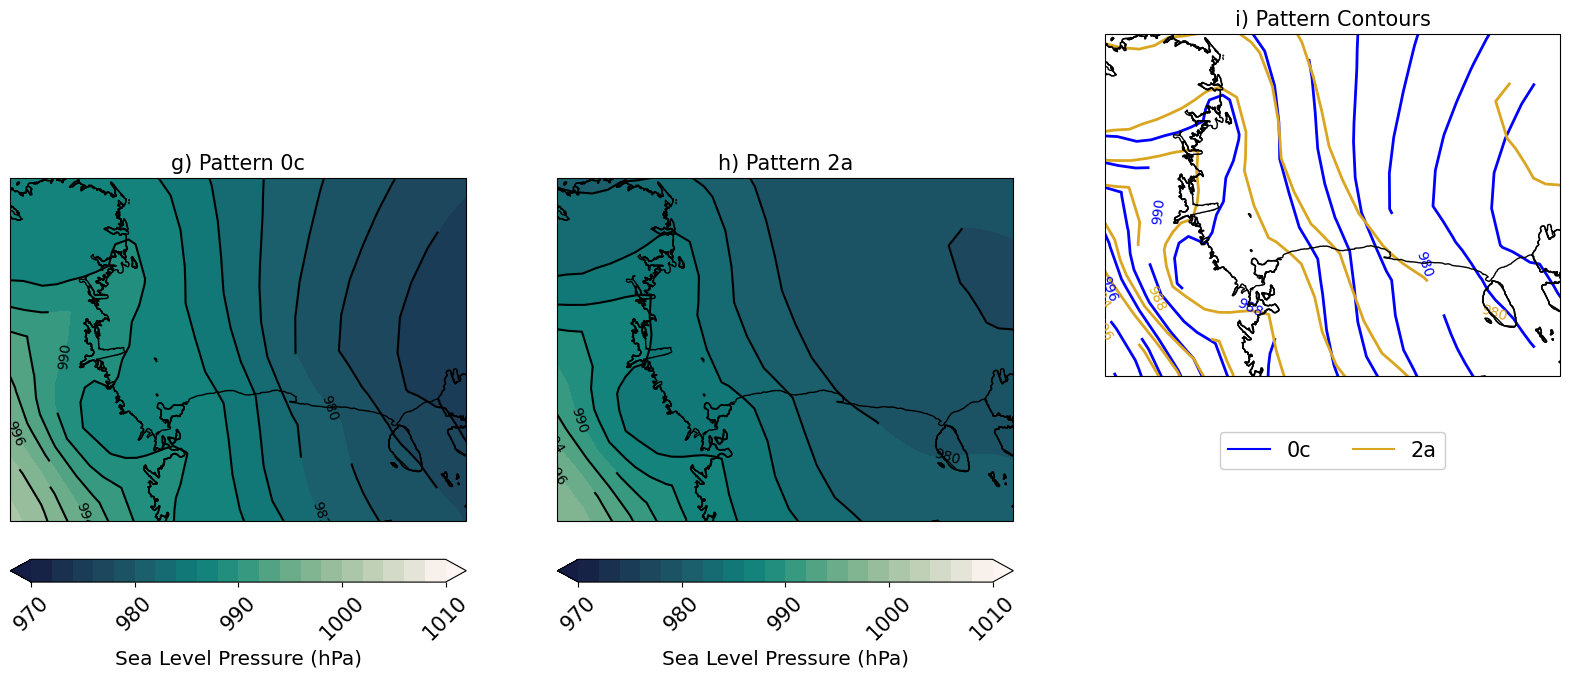

In [62]:
## Plot the composite from only nodes 0c and 2a
# get lat/lon
lats = ds.lat
lons = ds.lon

# select data
data_temp_1 = node_composite_all.isel(node=2)
data_temp_2 = node_composite_all.isel(node=6)
diff = data_temp_1 - data_temp_2
pcnt_diff = 100*((data_temp_1 - data_temp_2)/data_temp_2)

# create figure
fig = plt.figure(figsize=(20,10))

# plot the subplots - note it's nrow x ncol x index (starting upper left)
## plot 1
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_temp_1,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend=ext)
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,fraction=0.04,pad=0.05)
cbar.ax.tick_params(labelsize=15,rotation=45)
cbar.set_label(title_in+' '+units, fontsize='x-large')
# add contours overtop
this2 = ax.contour(lons,lats,
                   data_temp_1,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_in,extend=ext,linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_1+'Pattern 0c',fontsize=15)

## plot 2
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_temp_2,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend=ext)
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,fraction=0.04,pad=0.05)
cbar.ax.tick_params(labelsize=15,rotation=45)
cbar.set_label(title_in+' '+units, fontsize='x-large')
# add contours overtop
this2 = ax.contour(lons,lats,
                   data_temp_2,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_in,extend=ext,linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_2+'Pattern 2a',fontsize=15)

## plot 3
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
# Pattern 0c
color = 'blue'
this = ax.contour(lons,lats,
                   data_temp_1,
                   transform=ccrs.PlateCarree(),
                   colors = color, levels = levels_in,linewidths=2)
plt.clabel(this,colors=color,inline=1,fontsize=10)
# Pattern 2a
color = 'goldenrod'
this2 = ax.contour(lons,lats,
                   data_temp_2,
                   transform=ccrs.PlateCarree(),
                   colors = color, levels = levels_in,linewidths=2)
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.clabel(this2,colors=color,inline=1,fontsize=10)
# custom cbar stuff
#cbar = plt.colorbar(this,orientation='horizontal',ticks=[],fraction=0.03,pad=0.05)
#cbar.outline.set_color('white') # white out the colorbar so its not visible
# need colorbar to make all figs same location/height for auto scaling figure
# custom legend stuff
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', marker='None', linestyle='-',
                          markersize=10)
gold_line = mlines.Line2D([], [], color='goldenrod', marker='None', linestyle='-',
                          markersize=10)
ax.legend([blue_line,gold_line],['0c','2a'],
          fancybox=True, fontsize=15, ncol=2,loc='lower center',framealpha=1,bbox_to_anchor=(0.5,-0.3)).set_zorder(102)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
plt.title(pref_3+'Pattern Contours',fontsize=15)

# Finalize figure and save
if var_in == 'PSL':
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)